# TP 2 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [10]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

   Resolving package versions...


  No Changes to `~/Documents/RO/Project.toml`
  No Changes to `~/Documents/RO/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/RO/Project.toml`
  No Changes to `~/Documents/RO/Manifest.toml`


### Récupération des données

In [1]:
function readKnaptxtInstance(filename)
    price=Int64[]
    weight=Int64[]
    KnapCap=Int64[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [2]:
function testSondability_LP(remainingCapacity::Int64, listvals::Vector{Float64}, upperBound::Float64, BestProfit::Float64, Bestsol::Vector{Float64})
    TA, TO, TR = false, false, false
    if(remainingCapacity < 0)#Test de faisabilite
        TA=true
        println("TA")
    elseif(upperBound <= BestProfit) #Test d'optimalite
        TO=true
        println("TO")
    elseif( prod(abs.([round.(v, digits=0) for v in listvals]-listvals) .<= fill(10^-5, size(listvals))) 
        && prod([v .<= 1 for v in listvals])
        ) #Test de resolution
        TR=true
        println("TR")
        #if (value(benef) >= BestProfit)
        if (upperBound >= BestProfit)
            Bestsol = listvals
            #BestProfit=value(benef)
            BestProfit= upperBound
            println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        end
    else
        println("non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit
end

testSondability_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [3]:
function separateNodeThenchooseNext_lexicographic_depthfirst!(listobjs, listvals, n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left

    # lexicographic branching criterion: branch on the 1st object not yet fixed
    i, obj = 1, 0
    while((i <= n) && (obj==0))
        if(!(i in listobjs))
            obj=i
        end
        i+=1
    end

    println("\nbranch on object ", obj, "\n")

    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,obj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
end


function exploreNextNode_depthfirst!(listobjs, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible

    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
        end
        if theval==1.0
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return stop
end

exploreNextNode_depthfirst! (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): <span style="color:red"> SECTION A SUPPRIMER !!!! </span>

<span style="color:red"> Cette section est à commenter/supprimer et remplacer par vos propres calculs de bornes supérieures et autres, par exemple basées sur les bornes 1 et 2 vues en cours, ou d'autres calculs de bornes de votre choix/conception validés au préalable par votre encadrant/e de TP </span>

In [16]:
function sortIndexRatio(weight, price)
    # compute objects ratios
    ratio = Float64[]
    nbObj = length(weight)
    for i in 1:nbObj
        push!(ratio, price[i]/weight[i])
    end

    # return the list of objects index sorted by best ratio
    return sortperm(ratio, rev=true)
end

function upperBound1(price, weight, remainingCapacity, listobjs, listvals)
    listSortRatio = sortIndexRatio(weight, price)
    
    listxi = zeros(length(price))
    actualBenefit = 0
    for k in listobjs
        actualBenefit = actualBenefit + price[k]
        listxi[k] = listvals[k]
    end
    upperBound = actualBenefit
    if length(listobjs) < length(price)
        # find the best ratio object available
        i = first(filter(x -> !(x in listobjs), listSortRatio))
        upperBound = upperBound + remainingCapacity * price[i]/weight[i]
    end
    # value took for each x_i to compute the upper bound
    listxi[i] = remainingCapacity / weight[i]
    
    return upperBound, listxi
end

upperBound1 (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [5]:
function solveKnapInstance(filename)

    price, weight, capacity = readKnaptxtInstance(filename)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=Int64[]
    listvals=Float64[]
    for i in 1:length(price)
        push!(listvals, 0.0)
    end
    listnodes=Int64[]

    BestProfit::Float64=-1.0
    Bestsol=Float64[]

    remainingCapacity = capacity

    current_node_number::Int64=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)
        
        remainingCapacity = capacity
        for i in listobjs
            remainingCapacity = remainingCapacity - weight[i]
        end
        println("Remaining capacity: ", remainingCapacity)

        print("Compute upper bound: start ... ")

        upperBound, listxi = upperBound1(price, weight, remainingCapacity, listobjs, listvals)
        print(upperBound, " with ", listxi)

        println("... end"); 

        
        println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")

        TA, TO, TR, Bestsol, BestProfit = testSondability_LP(remainingCapacity, listxi, upperBound, BestProfit, Bestsol)

        is_node_sondable = TA || TO || TR


        if(!is_node_sondable)
            separateNodeThenchooseNext_lexicographic_depthfirst!(listobjs, listvals, length(price))
        else
            stop = exploreNextNode_depthfirst!(listobjs, listvals, listnodes)
        end
        
        current_node_number = current_node_number + 1
    end

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end

solveKnapInstance (generic function with 1 method)

### Affichage du résultat final

In [6]:
function solveNdisplayKnap(filename)

    println("\n Branch-and-Bound for solving a knapsack problem. \n\n Solving instance '" * filename * "'\n")

    BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = solveKnapInstance(filename)

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    println("\n Branch-and-bound tree visualization : start display ...")
    display(graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree))
    println("... end display. \n\n")

end

solveNdisplayKnap (generic function with 1 method)

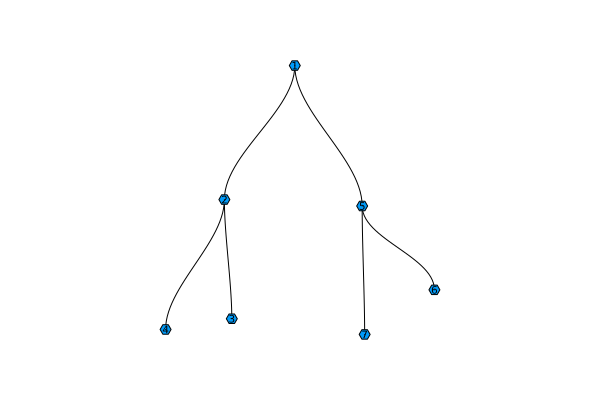


 Branch-and-Bound for solving a knapsack problem. 

 Solving instance 'InstancesKnapSack/test.opb.txt'


Node number 0: 
---------------

Remaining capacity: 10
Compute upper bound: start ... 100.0 with [0.0, 2.5, 0.0, 0.0]... end

Previous Solution memorized Float64[] with bestprofit -1.0

non sondable

branch on object 1


Node number 1: 
---------------

Remaining capacity: 3
Compute upper bound: start ... 72.0 with [0.0, 0.75, 0.0, 0.0]... end

Previous Solution memorized Float64[] with bestprofit -1.0

non sondable

branch on object 2


Node number 2: 
---------------

Remaining capacity: -1
Compute upper bound: start ... 77.0 with [0.0, 0.0, 0.0, -0.2]... end

Previous Solution memorized Float64[] with bestprofit -1.0

TA

Node number 3: 
---------------

Remaining capacity: -1
Compute upper bound: start ... 77.0 with [0.0, 0.0, 0.0, -0.2]... end

Previous Solution memorized Float64[] with bestprofit -1.0

TA

Node number 4: 
---------------

Remaining capacity: 3
Compute upper 

... end display. 


press enter to exit ! 


UndefVarError: UndefVarError: `execute_msg` not defined

In [17]:
INSTANCE = "InstancesKnapSack/test.opb.txt"

solveNdisplayKnap(INSTANCE)

println("press enter to exit ! ")
readline()

## Questions préliminaires

### Question 1.
La règle de séparation choisie est la règle lexicographique, c'est-à-dire que l'on branche sur le premier objet non-fixé en partant de l'objet 1.

### Question 2.
On trie d'abord  les objets par ratio décroissant et on sélectionne en entier les objets disponible de plus grand ratio pour lesquels la capacité du sac n'est pas dépassée. Dès qu'un objet ne peut plus rentrer entièrement, on n'en prend qu'une fraction permettant de remplir le sac.

### Question 3.
Le test d'admissibilité (TA) réussit si la capacité du restante du sac est négative. Le test d'optimalité (TO) réussit si la borne supérieure obtenue est moins bonne que la meilleure solution connue. Le test de réalisabilité (TR) réussit si le calcul de la borne supérieure donne des valeurs qui respectent les contraintes aux variables (ici binaire).

### Question 4.
La stratégie d'exploration est le parcours en profondeur à gauche.